In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#### The Medley Instruments Data Set

In [3]:
df = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata.csv')

In [4]:
df

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858
...,...,...,...,...,...
21566,validation,violin,7,226,fe4e8e98-6e0f-5a31-f446-99c10e0ac485
21567,validation,violin,7,226,aa606c78-9ee5-507f-f7e9-67c3530faf0f
21568,validation,violin,7,226,05e15c0a-d530-5f3e-fa82-58c55fa44993
21569,validation,violin,7,226,2dd485de-471d-5d8b-fe92-ef957dac021c


In [5]:
df.nunique()

subset               3
instrument           8
instrument_id        8
song_id            227
uuid4            21571
dtype: int64

In [6]:
df['instrument'].unique()

array(['clarinet', 'distorted electric guitar', 'female singer', 'flute',
       'piano', 'tenor saxophone', 'trumpet', 'violin'], dtype=object)

In [7]:
df.groupby(['instrument']).count()

,subset,instrument_id,song_id,uuid4
instrument,,,,
clarinet,1311,1311,1311,1311
distorted electric guitar,1854,1854,1854,1854
female singer,1744,1744,1744,1744
flute,3555,3555,3555,3555
piano,6032,6032,6032,6032
tenor saxophone,477,477,477,477
trumpet,627,627,627,627
violin,5971,5971,5971,5971


In [8]:
df.groupby(['instrument']).count().sum()

subset           21571
instrument_id    21571
song_id          21571
uuid4            21571
dtype: int64

In [9]:
df['subset'].unique()

array(['test', 'training', 'validation'], dtype=object)

In [10]:
df.groupby(['subset']).count()

,instrument,instrument_id,song_id,uuid4
subset,,,,
test,12236,12236,12236,12236
training,5841,5841,5841,5841
validation,3494,3494,3494,3494


Splitting Dataframe into Train, Validation and Test Dataframes

Saving once:

In [151]:
df.loc[df['subset']=='training']

,subset,instrument,instrument_id,song_id,uuid4
12236,training,clarinet,0,139,163fd2b1-8e98-515a-f501-4742cc6d066f
12237,training,clarinet,0,139,36dcb8eb-da46-5d01-fa9d-0f715c389379
12238,training,clarinet,0,139,9f6d4046-3662-5433-fc44-98c80a428fd8
12239,training,clarinet,0,139,5ef6a0ee-a092-5d49-f64e-a3454e9ab237
12240,training,clarinet,0,139,2048e98b-77b2-5b7d-fe6a-780f399e69fe
...,...,...,...,...,...
18072,training,violin,7,199,284c120e-0986-5220-ff20-a139682268a8
18073,training,violin,7,199,ac044390-8932-5ce7-f3d8-a1a0997f3be5
18074,training,violin,7,199,acfb1f64-e4ed-5422-fbc3-64366eac2fee
18075,training,violin,7,199,af6de7e1-bfee-545b-f114-00d2df94ad84


The following was done once, saving separated csv files for the subsets:

In [76]:
df.loc[df['subset']=='test'].to_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_test.csv')

In [77]:
df.loc[df['subset']=='training'].to_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_training.csv')

In [78]:
df.loc[df['subset']=='validation'].to_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_validation.csv')

Data Separated into Train, Validation, Test folders because loading the files with librosa resulted extremely slow

In [100]:
df_train = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_training.csv')

In [80]:
df_val = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_validation.csv')

In [81]:
df_test = pd.read_csv('~/documents/data/audio/medley/csv/Medley-solos-DB_metadata_test.csv')

In [106]:
df_train.rename(columns={'Unnamed: 0':'pos'},inplace=True)

In [107]:
df_val.rename(columns={'Unnamed: 0':'pos'},inplace=True)

In [108]:
df_test.rename(columns={'Unnamed: 0':'pos'},inplace=True)

In [141]:
df_train['instrument'][500]

'distorted electric guitar'

Load Audio Files from entire Dataset per Train, Validation and Test subsets

In [17]:
filename_pre = "Medley-solos-DB"

The following take too much time and the result cannot be handle computationally

In [140]:
folderpath = "../../../../../../documents/data/audio/medley/training/"
array_t_train=[]
for i in range(len(df_train)):
    filepath = folderpath+filename_pre+'_'+df_train['subset'][i]+'-'+str(df_train['instrument_id'][i])+'_'+df_train['uuid4'][i]+'.wav'
    array_1, sr = librosa.load(filepath)
    array_t_train.append(array_1)

In [141]:
folderpath = "../../../../../../documents/data/audio/medley/validation/"
array_t_val=[]
for i in range(len(df_val)):
    filepath = folderpath+filename_pre+'_'+df_val['subset'][i]+'-'+str(df_val['instrument_id'][i])+'_'+df_val['uuid4'][i]+'.wav'
    array_1, sr = librosa.load(filepath)
    array_t_val.append(array_1)

In [142]:
folderpath = "../../../../../../documents/data/audio/medley/test/"
array_t_test=[]
for i in range(len(df_test)):
    filepath = folderpath+filename_pre+'_'+df_test['subset'][i]+'-'+str(df_test['instrument_id'][i])+'_'+df_test['uuid4'][i]+'.wav'
    array_1, sr = librosa.load(filepath)
    array_t_test.append(array_1)

In [143]:
# proof that the array lists are correct and save them as csv

In [156]:
len(array_t_train)

5841

In [157]:
len(array_t_val)

3494

In [158]:
len(array_t_test)

12236

##### Simplifying the approach: model for two instruments

In [18]:
# working with the Train Set: 404 elements for each instrument

In [19]:
# begin with two instruments

In [147]:
df_train

,pos,subset,instrument,instrument_id,song_id,uuid4
0,12236,training,clarinet,0,139,163fd2b1-8e98-515a-f501-4742cc6d066f
1,12237,training,clarinet,0,139,36dcb8eb-da46-5d01-fa9d-0f715c389379
2,12238,training,clarinet,0,139,9f6d4046-3662-5433-fc44-98c80a428fd8
3,12239,training,clarinet,0,139,5ef6a0ee-a092-5d49-f64e-a3454e9ab237
4,12240,training,clarinet,0,139,2048e98b-77b2-5b7d-fe6a-780f399e69fe
...,...,...,...,...,...,...
5836,18072,training,violin,7,199,284c120e-0986-5220-ff20-a139682268a8
5837,18073,training,violin,7,199,ac044390-8932-5ce7-f3d8-a1a0997f3be5
5838,18074,training,violin,7,199,acfb1f64-e4ed-5422-fbc3-64366eac2fee
5839,18075,training,violin,7,199,af6de7e1-bfee-545b-f114-00d2df94ad84


In [161]:
instruments = df_train['instrument'].unique()

In [111]:
df_train.groupby(['instrument']).count()

,pos,subset,instrument_id,song_id,uuid4
instrument,,,,,
clarinet,251,251,251,251,251
distorted electric guitar,404,404,404,404,404
female singer,318,318,318,318,318
flute,155,155,155,155,155
piano,2401,2401,2401,2401,2401
tenor saxophone,123,123,123,123,123
trumpet,149,149,149,149,149
violin,2040,2040,2040,2040,2040


In [183]:
df_train_clarinet = df_train.loc[df_train['instrument_id']==0]

In [184]:
df_train_clarinet = df_train_clarinet.set_index('pos').reset_index()

In [185]:
df_train_guitar = df_train.loc[df_train['instrument_id']==1]

In [186]:
df_train_guitar = df_train_guitar.set_index('pos').reset_index()

In [187]:
df_train_singer = df_train.loc[df_train['instrument_id']==2]

In [188]:
df_train_singer = df_train_singer.set_index('pos').reset_index()

In [189]:
df_train_guitar.shape

(404, 6)

In [190]:
df_train_singer.shape

(318, 6)

In [119]:
# we are now working with the Training Data

In [120]:
filename_pre

'Medley-solos-DB'

In [191]:
df_train_guitar['instrument_id'][0]

1

Function for loading the files with librosa

In [218]:
def load_files(df):
    """loads audio files into a list with librosa
    expected is a dataframe of a single subset and instrument
    for example: training set, distorted electric guitar"""
    amplitude_df=[]
    subset = df['subset'][0]
    instrument_id = df['instrument_id'][0]
    folderpath = "../../../../../../documents/data/audio/medley/"+subset+"/"
    for file_id in df['uuid4']:
        filepath = folderpath+filename_pre+'_'+subset+'-'+str(instrument_id)+'_'+file_id+'.wav'
        amplitude_1, sr = librosa.load(filepath)
        amplitude_df.append(amplitude_1)
    return amplitude_df

In [219]:
amplitude_train_clarinet = load_files(df_train_clarinet)

In [220]:
amplitude_train_guitar = load_files(df_train_guitar)

In [221]:
amplitude_train_singer = load_files(df_train_singer)

In [212]:
array_df[0].shape

(65536,)

MEL SPECTROGRAM

In [229]:
mel_spectrogram_train_clarinet=[]

In [252]:
for amplitude_1 in amplitude_train_clarinet:
    mel_spectrogram_1 = librosa.feature.melspectrogram(amplitude_1,n_mels=90)
    mel_spectrogram_train_clarinet.append(mel_spectrogram_1)    

C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00017029  0.00023507  0.00021    ... -0.02615192 -0.02764189
 -0.03183531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.01607591  0.02279745  0.01802851 ... -0.02014576 -0.01923092
 -0.01869941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.02279647 -0.0331016  -0.02783431 ... -0.00502818 -0.0044317
 -0.00375655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.0101375  -0.00820964  0.00554882

In [233]:
len(mel_spectrogram_train_clarinet)

251

In [234]:
mel_spectrogram_train_clarinet[0].shape

(90, 129)

In [236]:
X_tr_clarinet = np.stack(mel_spectrogram_train_clarinet,axis=0)
X_tr_clarinet.shape

(251, 90, 129)

In [237]:
mel_spectrogram_train_guitar=[]

In [238]:
for amplitude_1 in amplitude_train_guitar:
    mel_spectrogram_1 = librosa.feature.melspectrogram(amplitude_1, sr=22050, n_fft=2048, hop_length=512, n_mels=90)
    mel_spectrogram_train_guitar.append(mel_spectrogram_1)    

C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00223903 -0.00505312 -0.03948023 ... -0.00945104 -0.00490245
  0.0062861 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.10711695  0.14358008  0.04453898 ... -0.04741929 -0.05991799
 -0.13782972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.00868413 0.00933887 0.00133363 ... 0.03203008 0.02401079 0.00445854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.12492672 -0.13247724 -0.04789928 ...  

In [239]:
len(mel_spectrogram_train_guitar)

404

In [240]:
mel_spectrogram_train_clarinet[0].shape

(90, 129)

In [242]:
X_tr_guitar = np.stack(mel_spectrogram_train_guitar,axis=0)
X_tr_guitar.shape

(404, 90, 129)

In [268]:
y_tr_guitar = np.ones((404,1))

In [264]:
X_tr_guitar_resh = X_tr_guitar.reshape(404,90,129,1)

In [244]:
mel_spectrogram_train_singer=[]

In [245]:
for amplitude_1 in amplitude_train_singer:
    mel_spectrogram_1 = librosa.feature.melspectrogram(amplitude_1, sr=22050, n_fft=2048, hop_length=512, n_mels=90)
    mel_spectrogram_train_singer.append(mel_spectrogram_1)    

C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.0003303  -0.00040205 -0.00031644 ... -0.00508585 -0.000867
  0.00390803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.00045925 0.00087499 0.00148983 ... 0.00702136 0.00830677 0.01070923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00358028  0.00376304 -0.00024948 ...  0.02597795  0.036274
  0.04518853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00828164  0.01257262  0.01069835 ... -0.01

In [246]:
len(mel_spectrogram_train_singer)

318

In [247]:
mel_spectrogram_train_singer[0].shape

(90, 129)

In [253]:
X_tr_singer = np.stack(mel_spectrogram_train_singer,axis=0)
X_tr_singer.shape

(318, 90, 129)

In [269]:
y_tr_singer = np.zeros((318,1))

In [261]:
X_tr_singer_resh = X_tr_singer.reshape(318,90,129,-1)

In [262]:
X_tr_singer_resh.shape

(318, 90, 129, 1)

In [ ]:
# X_train shape (number wav files, f domain, t domain, 1)
# number wav guitar + singer = 404 +318 = 722
(722, 90, 129)

In [266]:
X_train = np.concatenate([X_tr_guitar_resh, X_tr_singer_resh])

In [267]:
X_train.shape

(722, 90, 129, 1)

In [270]:
y_train = np.concatenate([y_tr_guitar, y_tr_singer])

In [271]:
y_train.shape

(722, 1)

In [283]:
# One hot encode the labels:
# Keep a copy of y test as the actual number labels:
y_train_true = y_train.copy()

In [284]:
y_train = to_categorical(y_train)

In [285]:
y_train.shape

(722, 2)

In [287]:
# model
# Clear session and build above model:
K.clear_session()

model = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid',
           activation = 'relu' ,input_shape = (90,129,1)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),

    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'valid'),
    
    Flatten(),
    #Fully connected layers:
    Dense(100,activation='relu'),
    #Dropout(0.2), - optional
    Dense(2,activation= 'softmax')

    
])

In [288]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 88, 127, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10080)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1008100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [289]:
# compile model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [290]:
# fit the model
history = model.fit(X_train,y_train,batch_size=600, epochs=10,validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 1.0084 - accuracy: 0.3865 - val_loss: 16.3417 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 4.0230 - accuracy: 0.7002 - val_loss: 3.6992 - val_accuracy: 0.3034
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.5910 - accuracy: 0.8180 - val_loss: 0.1648 - val_accuracy: 0.9724
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 1.0129 - accuracy: 0.6187 - val_loss: 0.1182 - val_accuracy: 0.9931
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 1.1498 - accuracy: 0.5702 - val_loss: 0.1640 - val_accuracy: 0.9793
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.7783 - accuracy: 0.6534 - val_loss: 0.3280 - val_accuracy: 0.9379
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.4783 - accuracy: 0.8128 - val_loss: 0.7701 - val_accuracy: 0.8414
Epoch 8/10
1/1 [====================

In [ ]:
# examine the model

In [291]:
history.history

{'loss': [1.008364200592041,
  4.022989749908447,
  0.5910283923149109,
  1.012922763824463,
  1.1498299837112427,
  0.7783034443855286,
  0.4782942235469818,
  0.3375036418437958,
  0.2836433947086334,
  0.2854127585887909],
 'accuracy': [0.38648179173469543,
  0.7001733183860779,
  0.8180242776870728,
  0.6187174916267395,
  0.5701906681060791,
  0.6533795595169067,
  0.8128249645233154,
  0.923743486404419,
  0.8994800448417664,
  0.8804159164428711],
 'val_loss': [16.341650009155273,
  3.699237585067749,
  0.1647663116455078,
  0.11823754012584686,
  0.16402925550937653,
  0.32804831862449646,
  0.7701122760772705,
  1.499894142150879,
  2.216235876083374,
  2.7251203060150146],
 'val_accuracy': [0.0,
  0.30344828963279724,
  0.9724137783050537,
  0.9931034445762634,
  0.9793103337287903,
  0.9379310607910156,
  0.8413792848587036,
  0.7103448510169983,
  0.5517241358757019,
  0.4206896424293518]}

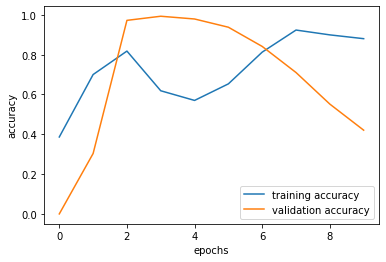

In [292]:
# Plot accuracy curve
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

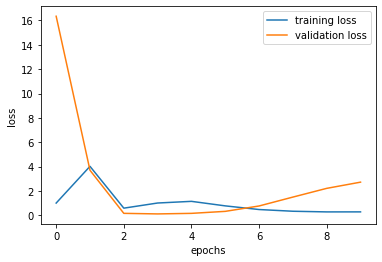

In [293]:
# Plot loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# confusion matrix

#### Pre trained CNN